In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.models._utils as _utils
from torch.autograd import Variable


#---------------------------------------------------#
#   卷积块
#   Conv2D + BatchNormalization + LeakyReLU
#---------------------------------------------------#
def conv_bn(inp, oup, stride = 1, leaky = 0):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope=leaky, inplace=True)
    )
def conv_bn1X1(inp, oup, stride, leaky=0):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, stride, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope=leaky, inplace=True)
    )

#---------------------------------------------------#
#   卷积块
#   Conv2D + BatchNormalization
#---------------------------------------------------#
def conv_bn_no_relu(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
    )

#---------------------------------------------------#
#   多尺度加强感受野
#---------------------------------------------------#
class SSH(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(SSH, self).__init__()
        assert out_channel % 4 == 0
        leaky = 0
        if (out_channel <= 64):
            leaky = 0.1

        # 3x3卷积
        self.conv3X3 = conv_bn_no_relu(in_channel, out_channel//2, stride=1)

        # 利用两个3x3卷积替代5x5卷积
        self.conv5X5_1 = conv_bn(in_channel, out_channel//4, stride=1, leaky = leaky)
        self.conv5X5_2 = conv_bn_no_relu(out_channel//4, out_channel//4, stride=1)

        # 利用三个3x3卷积替代7x7卷积
        self.conv7X7_2 = conv_bn(out_channel//4, out_channel//4, stride=1, leaky = leaky)
        self.conv7x7_3 = conv_bn_no_relu(out_channel//4, out_channel//4, stride=1)

    def forward(self, inputs):
        conv3X3 = self.conv3X3(inputs)

        conv5X5_1 = self.conv5X5_1(inputs)
        conv5X5 = self.conv5X5_2(conv5X5_1)

        conv7X7_2 = self.conv7X7_2(conv5X5_1)
        conv7X7 = self.conv7x7_3(conv7X7_2)
        
        # 所有结果堆叠起来
        out = torch.cat([conv3X3, conv5X5, conv7X7], dim=1)
        out = F.relu(out)
        return out

class FPN(nn.Module):
    def __init__(self,in_channels_list,out_channels):
        super(FPN,self).__init__()
        leaky = 0
        if (out_channels <= 64):
            leaky = 0.1
        self.output1 = conv_bn1X1(in_channels_list[0], out_channels, stride = 1, leaky = leaky)
        self.output2 = conv_bn1X1(in_channels_list[1], out_channels, stride = 1, leaky = leaky)
        self.output3 = conv_bn1X1(in_channels_list[2], out_channels, stride = 1, leaky = leaky)

        self.merge1 = conv_bn(out_channels, out_channels, leaky = leaky)
        self.merge2 = conv_bn(out_channels, out_channels, leaky = leaky)

    def forward(self, inputs):
        #-------------------------------------------#
        #   获得三个shape的有效特征层
        #   分别是C3  80, 80, 64
        #         C4  40, 40, 128
        #         C5  20, 20, 256
        #-------------------------------------------#
        inputs = list(inputs.values())

        #-------------------------------------------#
        #   获得三个shape的有效特征层
        #   分别是output1  80, 80, 64
        #         output2  40, 40, 64
        #         output3  20, 20, 64
        #-------------------------------------------#
        output1 = self.output1(inputs[0])
        output2 = self.output2(inputs[1])
        output3 = self.output3(inputs[2])

        #-------------------------------------------#
        #   output3上采样和output2特征融合
        #   output2  40, 40, 64
        #-------------------------------------------#
        up3 = F.interpolate(output3, size=[output2.size(2), output2.size(3)], mode="nearest")
        output2 = output2 + up3
        output2 = self.merge2(output2)

        #-------------------------------------------#
        #   output2上采样和output1特征融合
        #   output1  80, 80, 64
        #-------------------------------------------#
        up2 = F.interpolate(output2, size=[output1.size(2), output1.size(3)], mode="nearest")
        output1 = output1 + up2
        output1 = self.merge1(output1)

        out = [output1, output2, output3]
        return out

In [2]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.models._utils as _utils
from torch.autograd import Variable


def conv_bn(inp, oup, stride = 1, leaky = 0.1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope=leaky, inplace=True)
    )
    
def conv_dw(inp, oup, stride = 1, leaky=0.1):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.LeakyReLU(negative_slope= leaky,inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope= leaky,inplace=True),
    )

In [3]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models._utils as _utils
import torchvision.models.detection.backbone_utils as backbone_utils
from torchvision import models


#---------------------------------------------------#
#   人脸关键点预测
#---------------------------------------------------#
class LandmarkHead(nn.Module):
    def __init__(self,inchannels=512, outchannels=1024):
        super(LandmarkHead,self).__init__()
        
#         self.conv3x3 = nn.Conv2d(inchannels, outchannels, kernel_size=(3,3),stride=1,padding=0)
        self.conv3x3 = conv_bn(inchannels, outchannels)
        self.conv1x1 = nn.Conv2d(inchannels, outchannels, kernel_size=(1,1),stride=1,padding=0)
        self.avg = nn.AdaptiveAvgPool2d((1,1))

    def forward(self,x):
        x = self.conv3x3(x)
        out = self.conv1x1(x)
        out = self.avg(out)

        return out.view(out.shape[0], -1)

class RetinaFace(nn.Module):
    def __init__(self, cfg = None, pretrained = True, mode = 'train'):
        super(RetinaFace,self).__init__()
        backbone = None
        if cfg['name'] == 'mobilenet0.25':
            backbone = MobileNetV1()
            if pretrained:
                checkpoint = torch.load("./model_data/mobilenetV1X0.25_pretrain.tar", map_location=torch.device('cpu'))
                from collections import OrderedDict
                new_state_dict = OrderedDict()
                for k, v in checkpoint['state_dict'].items():
                    name = k[7:]
                    new_state_dict[name] = v
                backbone.load_state_dict(new_state_dict)
        elif cfg['name'] == 'Resnet50':
            backbone = models.resnet50(pretrained=pretrained)

        self.body = _utils.IntermediateLayerGetter(backbone, cfg['return_layers'])

        # 获得每个初步有效特征层的通道数
        in_channels_list = [cfg['in_channel'] * 2, cfg['in_channel'] * 4, cfg['in_channel'] * 8]
        self.fpn = FPN(in_channels_list, cfg['out_channel'])
        # 利用ssh模块提高模型感受野
        self.ssh1 = SSH(cfg['out_channel'], cfg['out_channel'])
        self.ssh2 = SSH(cfg['out_channel'], cfg['out_channel'])
        self.ssh3 = SSH(cfg['out_channel'], cfg['out_channel'])

        self.LandmarkHead = self._make_landmark_head(fpn_num=3, inchannels=cfg['out_channel'])

        self.mode = mode
        self.fc = nn.Sequential(nn.Linear(768,8),
                                nn.Tanh()
                               )


    def _make_landmark_head(self,fpn_num=3,inchannels=64):
        landmarkhead = nn.ModuleList()
        for i in range(fpn_num):
            landmarkhead.append(LandmarkHead(inchannels,inchannels))
        return landmarkhead

    def forward(self,inputs):
        #-------------------------------------------#
        #   获得三个shape的有效特征层
        #   分别是C3  80, 80, 64
        #         C4  40, 40, 128
        #         C5  20, 20, 256
        #-------------------------------------------#
        out = self.body.forward(inputs)

        #-------------------------------------------#
        #   获得三个shape的有效特征层
        #   分别是output1  80, 80, 64
        #         output2  40, 40, 64
        #         output3  20, 20, 64
        #-------------------------------------------#
        fpn = self.fpn.forward(out)

        feature1 = self.ssh1(fpn[0])

        feature2 = self.ssh2(fpn[1])

        feature3 = self.ssh3(fpn[2])

        features = [feature1, feature2, feature3]

        #-------------------------------------------#
        #   将所有结果进行堆叠
        #-------------------------------------------#
#         bbox_regressions = torch.cat([self.BboxHead[i](feature) for i, feature in enumerate(features)], dim=1)
#         classifications = torch.cat([self.ClassHead[i](feature) for i, feature in enumerate(features)], dim=1)
        ldm_regressions = torch.cat([self.LandmarkHead[i](feature) for i, feature in enumerate(features)], dim=1)

        return self.fc(ldm_regressions)
    
    
cfg_re50 = {
    'name': 'Resnet50',
    'min_sizes': [[8, 16], [32, 64], [128, 256]],
    'steps': [8, 16, 32],
    'variance': [0.1, 0.2],
    'clip': False,
    'loc_weight': 2.0,
    'train_image_size': 192,
    'return_layers': {'layer2': 1, 'layer3': 2, 'layer4': 3},
    'in_channel': 256,
    'out_channel': 256
}

img = torch.randn((70,3,192,192))
net = RetinaFace(cfg=cfg_re50)
net(img).shape

torch.Size([70, 8])

In [4]:
import os, sys, codecs, glob
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import cv2

import torch
torch.backends.cudnn.benchmark = False
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [6]:
train_df = pd.read_csv('data/train.csv')
# train_df = train_df.fillna(-1)

# 缺失值处理
# 去掉缺失值行   预测的时候加入训练集继续训练
train_df = train_df.dropna(axis = 0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4965 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          4965 non-null   float64
 1   left_eye_center_y          4965 non-null   float64
 2   right_eye_center_x         4965 non-null   float64
 3   right_eye_center_y         4965 non-null   float64
 4   nose_tip_x                 4965 non-null   float64
 5   nose_tip_y                 4965 non-null   float64
 6   mouth_center_bottom_lip_x  4965 non-null   float64
 7   mouth_center_bottom_lip_y  4965 non-null   float64
dtypes: float64(8)
memory usage: 349.1 KB


In [7]:
train_img = np.load('data/train.npy')[:,:,list(train_df.index)]
test_img = np.load('data/test.npy')

In [7]:
train_img.shape

(96, 96, 4965)

In [17]:
import cv2
import albumentations as A


def flip(img, annotation):

    img = np.fliplr(img).copy()
    h, w = img.shape[:2]

    x_min, y_min, x_max, y_max = [0,0,h,w]
    landmark_x = annotation[0::2]
    landmark_y = annotation[1::2]

    bbox = np.array([w - x_max, y_min, w - x_min, y_max])
    for i in range(len(landmark_x)):
        if landmark_x[i] == -1:
            landmark_x[i] = landmark_x[i]
        else:
            landmark_x[i] = w - landmark_x[i]

    # 左右眼交换
    landmark_x[0], landmark_x[1] = landmark_x[1], landmark_x[0]
    landmark_y[0], landmark_y[1] = landmark_y[1], landmark_y[0]
    new_annotation = list()


    for i in range(len(landmark_x)):
        new_annotation.append(landmark_x[i])
        new_annotation.append(landmark_y[i])

    return img, new_annotation




def scale(img, annotation,f_xy=2):
    origin_h, origin_w = img.shape[:2]

    bbox = [0,0,origin_h,origin_w]
    landmark_x = annotation[0::2]
    landmark_y = annotation[1::2]

    h, w = int(origin_h * f_xy), int(origin_w * f_xy)
    image = cv2.resize(img, (h, w)).astype(np.uint8)

    new_annotation = list()


    for i in range(len(landmark_x)):
        landmark_x[i] = landmark_x[i] * f_xy
        landmark_y[i] = landmark_y[i] * f_xy
        new_annotation.append(landmark_x[i])
        new_annotation.append(landmark_y[i])

    return image, new_annotation




def rotate(img, annotation, alpha=30):

    h, w = img.shape[:2]
    bbox = [0,0,h,w]

    landmark_x = annotation[0::2]
    landmark_y = annotation[1::2]

    center = ((bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2)
    rot_mat = cv2.getRotationMatrix2D(center, alpha, 1)
    img_rotated_by_alpha = cv2.warpAffine(img, rot_mat,
                                          (img.shape[1], img.shape[0]))

    point_x = [bbox[0], bbox[2], bbox[0], bbox[2]]
    point_y = [bbox[1], bbox[3], bbox[3], bbox[1]]


    new_annotation = list()

    for (x, y) in zip(landmark_x, landmark_y):
        if x == -1:
            new_annotation.append(x)
            new_annotation.append(y)
        else:
            new_annotation.append(rot_mat[0][0] * x + rot_mat[0][1] * y +
                                  rot_mat[0][2])
            new_annotation.append(rot_mat[1][0] * x + rot_mat[1][1] * y +
                                  rot_mat[1][2])

    return img_rotated_by_alpha, new_annotation


transform_Resize = A.Compose(
    [A.Resize (192,192)], 
     keypoint_params=A.KeypointParams(format='xy')
)

def Crop_top(img, annotation,margin=15):
    origin_h, origin_w = img.shape[:2]

    landmark_x = annotation[0::2]
    landmark_y = annotation[1::2]
    min_y = max(int(min(landmark_y) - margin),0)
    image = img[min_y:,:]

    new_annotation = list()


    for i in range(len(landmark_y)):
        landmark_y[i] = landmark_y[i] - min_y
        new_annotation.append(landmark_x[i])
        new_annotation.append(landmark_y[i])
        
    # resize
    transformed = transform_Resize(image=image, keypoints=np.array(new_annotation).reshape(-1,2))

    return transformed['image'], transformed['keypoints']


def Crop_left(img, annotation,margin):
    origin_h, origin_w = img.shape[:2]

    landmark_x = annotation[0::2]
    landmark_y = annotation[1::2]
    min_x = max(0,int(min(landmark_x) - margin))
    image = img[:,min_x:]

    new_annotation = list()


    for i in range(len(landmark_y)):
        landmark_x[i] = landmark_x[i] - min_x
        new_annotation.append(landmark_x[i])
        new_annotation.append(landmark_y[i])
        
    # resize
    transformed = transform_Resize(image=image, keypoints=np.array(new_annotation).reshape(-1,2))

    return transformed['image'], transformed['keypoints']

def Crop_bottom(img, annotation,margin):
    origin_h, origin_w = img.shape[:2]

    landmark_x = annotation[0::2]
    landmark_y = annotation[1::2]
    max_y = min(int(max(landmark_y) + margin),192)
    image = img[:max_y,:]

    new_annotation = list()


    for i in range(len(landmark_y)):

        new_annotation.append(landmark_x[i])
        new_annotation.append(landmark_y[i])
        
    # resize
    transformed = transform_Resize(image=image, keypoints=np.array(new_annotation).reshape(-1,2))

    return transformed['image'], transformed['keypoints']


def Crop_right(img, annotation,margin):
    origin_h, origin_w = img.shape[:2]

    landmark_x = annotation[0::2]
    landmark_y = annotation[1::2]
    max_x = min(int(max(landmark_x) + margin),192)
    image = img[:,:max_x]

    new_annotation = list()


    for i in range(len(landmark_y)):

        new_annotation.append(landmark_x[i])
        new_annotation.append(landmark_y[i])
        
    # resize
    transformed = transform_Resize(image=image, keypoints=np.array(new_annotation).reshape(-1,2))

    return transformed['image'], transformed['keypoints']

# 数据增强

In [9]:




transform_RandomContrast = A.Compose(
    [A.RandomContrast(p=1)], 
    keypoint_params=A.KeypointParams(format='xy')
)
# # %pylab inline
# transformed = transform(image=aug_imgs[4500], keypoints=np.array(aug_points[4500]).reshape(-1,2))
# transformed['keypoints'] = np.array(transformed['keypoints'])

# plt.scatter(transformed['keypoints'][:,0], transformed['keypoints'][:,1])
# plt.imshow(transformed['image'], cmap='gray')

transform_RandomBrightnessContrast = A.Compose(
    [A.RandomBrightnessContrast(p=1)], 
    keypoint_params=A.KeypointParams(format='xy')
)

transform_Blur = A.Compose(
    [A.Blur(p=0.5)], 
    keypoint_params=A.KeypointParams(format='xy')
)


transform_CropAndPad = A.Compose(
    [A.CropAndPad(percent=0.1,pad_cval=50)], 
     keypoint_params=A.KeypointParams(format='xy')
)


# %pylab inline
# transformed = transform_ShiftScaleRotate(image=aug_imgs[1], keypoints=np.array(aug_points[1]).reshape(-1,2))

# transformed['keypoints'] = np.array(transformed['keypoints'])

# plt.scatter(transformed['keypoints'][:,0], transformed['keypoints'][:,1])
# plt.imshow(transformed['image'], cmap='gray')

/home/fqh/anaconda3/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1772: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [10]:
from  itertools import chain

aug_imgs = []
aug_points = []

# step1:放大到 96 * 2 = 192
for i in range(train_img.shape[-1]):
    aug, pnt = scale(train_img[:,:,i], list(train_df.iloc[i].values))
    aug_imgs.append(aug)
    aug_points.append(pnt)
    
# step2: 水平翻转 + 旋转5  + 旋转10  + 旋转 15 + 旋转 20
img_len = len(aug_imgs)
for i in range(img_len):
    aug1, pnt1 = flip(aug_imgs[i], aug_points[i])
    aug_imgs.append(aug1)
    aug_points.append(pnt1)
    
    aug2, pnt2 = rotate(aug_imgs[i], aug_points[i], 10)
    aug_imgs.append(aug2)
    aug_points.append(pnt2)
    
    aug3, pnt3 = rotate(aug_imgs[i], aug_points[i], 20)
    aug_imgs.append(aug3)
    aug_points.append(pnt3)
    
    aug4, pnt4 = rotate(aug_imgs[i], aug_points[i], 30)
    aug_imgs.append(aug4)
    aug_points.append(pnt4)
    
    aug5, pnt5 = rotate(aug_imgs[i], aug_points[i], -20)
    aug_imgs.append(aug5)
    aug_points.append(pnt5)
    
    aug6, pnt6 = rotate(aug_imgs[i], aug_points[i], -30)
    aug_imgs.append(aug6)
    aug_points.append(pnt6)
    
    aug7, pnt7 = rotate(aug_imgs[i], aug_points[i], -60)
    aug_imgs.append(aug7)
    aug_points.append(pnt7)
    
    aug8, pnt8 = rotate(aug_imgs[i], aug_points[i], 60)
    aug_imgs.append(aug8)
    aug_points.append(pnt8)
    
#     albumentations 增强
    transformed = transform_RandomContrast(image=aug_imgs[i], keypoints=np.array(aug_points[i]).reshape(-1,2))
    aug_imgs.append(transformed['image'])
    aug_points.append(list(chain.from_iterable(transformed['keypoints'])))
    
    transformed = transform_RandomBrightnessContrast(image=aug_imgs[i], keypoints=np.array(aug_points[i]).reshape(-1,2))
    aug_imgs.append(transformed['image'])
    aug_points.append(list(chain.from_iterable(transformed['keypoints'])))
    
    transformed = transform_Blur(image=aug_imgs[i], keypoints=np.array(aug_points[i]).reshape(-1,2))
    aug_imgs.append(transformed['image'])
    aug_points.append(list(chain.from_iterable(transformed['keypoints'])))

    transformed = transform_CropAndPad(image=aug_imgs[i], keypoints=np.array(aug_points[i]).reshape(-1,2))
    aug_imgs.append(transformed['image'])
    aug_points.append(list(chain.from_iterable(transformed['keypoints'])))
    
    
    aug9, pnt9 = Crop_top(aug_imgs[i], aug_points[i],10)
    aug_imgs.append(aug9)
    aug_points.append(list(chain.from_iterable(pnt9)))
    
    aug10, pnt10 = Crop_left(aug_imgs[i], aug_points[i],10)
    aug_imgs.append(aug10)
    aug_points.append(list(chain.from_iterable(pnt10)))
    
    aug11, pnt11 = Crop_bottom(aug_imgs[i], aug_points[i],10)
    aug_imgs.append(aug11)
    aug_points.append(list(chain.from_iterable(pnt11)))
    
    
    aug12, pnt12 = Crop_right(aug_imgs[i], aug_points[i],10)
    aug_imgs.append(aug12)
    aug_points.append(list(chain.from_iterable(pnt12)))
    
    
    aug13, pnt13 = Crop_top(aug_imgs[i], aug_points[i],5)
    aug_imgs.append(aug13)
    aug_points.append(list(chain.from_iterable(pnt13)))
    
    aug14, pnt14 = Crop_left(aug_imgs[i], aug_points[i],5)
    aug_imgs.append(aug14)
    aug_points.append(list(chain.from_iterable(pnt14)))
    
    aug15, pnt15 = Crop_bottom(aug_imgs[i], aug_points[i],5)
    aug_imgs.append(aug15)
    aug_points.append(list(chain.from_iterable(pnt15)))
    
    
    aug16, pnt16 = Crop_right(aug_imgs[i], aug_points[i],5)
    aug_imgs.append(aug16)
    aug_points.append(list(chain.from_iterable(pnt16)))
    
    
    aug17, pnt17 = Crop_top(aug_imgs[i], aug_points[i],15)
    aug_imgs.append(aug17)
    aug_points.append(list(chain.from_iterable(pnt17)))
    
    aug18, pnt18 = Crop_left(aug_imgs[i], aug_points[i],15)
    aug_imgs.append(aug18)
    aug_points.append(list(chain.from_iterable(pnt18)))
    
    aug19, pnt19 = Crop_bottom(aug_imgs[i], aug_points[i],15)
    aug_imgs.append(aug19)
    aug_points.append(list(chain.from_iterable(pnt19)))
    
    
    aug20, pnt20 = Crop_right(aug_imgs[i], aug_points[i],15)
    aug_imgs.append(aug20)
    aug_points.append(list(chain.from_iterable(pnt20)))
    
    
    
    
    aug21, pnt21 = Crop_top(aug_imgs[i], aug_points[i],25)
    aug_imgs.append(aug21)
    aug_points.append(list(chain.from_iterable(pnt21)))
    
    aug22, pnt22 = Crop_left(aug_imgs[i], aug_points[i],25)
    aug_imgs.append(aug22)
    aug_points.append(list(chain.from_iterable(pnt22)))
    
    aug23, pnt23 = Crop_bottom(aug_imgs[i], aug_points[i],25)
    aug_imgs.append(aug23)
    aug_points.append(list(chain.from_iterable(pnt23)))
    
    
    aug24, pnt24 = Crop_right(aug_imgs[i], aug_points[i],25)
    aug_imgs.append(aug24)
    aug_points.append(list(chain.from_iterable(pnt24)))

In [11]:
len(aug_imgs)

143985

In [12]:
aug_imgs = np.array(aug_imgs)
aug_imgs.shape

(143985, 192, 192)

In [13]:
aug_points = np.vstack(aug_points)
aug_points.shape

(143985, 8)

In [14]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True).float()
        target = target.cuda(non_blocking=True).float()

        output = model(input)
        loss = criterion(target,output)
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(loss.item())
            
def validate(val_loader, model):
    model.eval()
    
    val_feats = []
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda().float()
            target = target.cuda().float()
            output = model(input)
            val_feats.append(output.data.cpu().numpy())
    return val_feats

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import math


class XunFeiDataset(Dataset):
    def __init__(self, img, keypoint, transform=None):
        self.img = img
        self.transform = transform
        self.keypoint = keypoint

    def __getitem__(self, index):
        img = Image.fromarray(self.img[index,:,:]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        return img, (self.keypoint[index] - 96.0) / 96.0

    def __len__(self):
        return len(self.img)
    
    
class WingLoss(nn.Module):

    def __init__(self, wing_w=10.0, wing_epsilon=2.0):
        super(WingLoss, self).__init__()
        self.wing_w = wing_w
        self.wing_epsilon = wing_epsilon
        self.wing_c = self.wing_w * (1.0 - math.log(1.0 + self.wing_w / self.wing_epsilon))

    def forward(self, targets, predictions, euler_angle_weights=None):
        abs_error = torch.abs(targets - predictions)
        loss = torch.where(torch.le(abs_error, self.wing_w),
                           self.wing_w * torch.log(1.0 + abs_error / self.wing_epsilon), abs_error - self.wing_c)
        loss_sum = torch.sum(loss, 1)
        if euler_angle_weights is not None:
            loss_sum *= euler_angle_weights
        return torch.mean(loss_sum)

In [16]:
import copy

kfold = KFold(n_splits=5)
fold = 0
for tr_idx, val_idx, in kfold.split([1]*aug_imgs.shape[0]):
    model = copy.deepcopy(net).cuda()
    print(val_idx)

    train_loader = torch.utils.data.DataLoader(
        XunFeiDataset(aug_imgs[tr_idx,:,:],  aug_points[tr_idx],
                      transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])),
        batch_size=100, shuffle=True, num_workers=5,
    )

    val_loader = torch.utils.data.DataLoader(
        XunFeiDataset(aug_imgs[val_idx,:,:], aug_points[val_idx], 
                      transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])
        ),
        batch_size=70, shuffle=False, num_workers=5,
    )

    criterion = WingLoss()
    optimizer = torch.optim.Adam(model.parameters(), 0.0008)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.85)
    best_acc = 0.0

    for epoch in range(10):
        print('Epoch: ', epoch)

        train(train_loader, model, criterion, optimizer, epoch)

        val_feats = validate(val_loader, model)
        scheduler.step()
        
        val_feats = np.vstack(val_feats) * 96 + 96
        print('Val', mean_absolute_error(val_feats, aug_points[val_idx]))
    
    torch.save(model.state_dict(), 'model_{0}.pt'.format(fold))
    fold += 1

[    0     1     2 ... 28794 28795 28796]
Epoch:  0
2.582261323928833
2.4512734413146973
2.436228036880493
1.7453076839447021
1.701219081878662
1.8597807884216309
1.5462820529937744
1.4478613138198853
1.3766098022460938
1.3386259078979492
1.4706954956054688
Val 3.6670450572754865
Epoch:  1
1.1582984924316406
1.4221023321151733
1.337367057800293
1.1093602180480957
1.2150065898895264
1.1791526079177856
1.146264672279358
1.0871273279190063
1.1801494359970093
0.973814070224762
1.2379060983657837
Val 2.582156415671346
Epoch:  2
1.0962378978729248
1.2922881841659546
0.9709797501564026
1.0104061365127563
0.9340394139289856
0.9586074352264404
1.3289000988006592
1.280418038368225
0.9959812760353088
1.0762490034103394
1.0832655429840088
Val 2.7515032164079694
Epoch:  3
0.8357096910476685
0.9748367071151733
0.9340300559997559
1.0041629076004028
0.9521289467811584
0.8640638589859009
1.0385782718658447
0.9976063370704651
0.8601639866828918
0.8577284812927246
0.9785712361335754
Val 2.396827298790098

0.9306113719940186
0.8565680980682373
0.8517864942550659
0.8921642303466797
0.7235832214355469
0.9562203884124756
Val 2.501021110149283
Epoch:  4
0.6890254020690918
0.6455858945846558
0.7553024291992188
0.9304329752922058
0.6836338639259338
0.7536076307296753
0.6160030364990234
0.689404308795929
0.6429165005683899
0.912403404712677
0.7040455937385559
Val 2.5536317994085653
Epoch:  5
0.6536217331886292
0.6544385552406311
0.7129883170127869
0.5896115899085999
0.6050411462783813
0.558376133441925
0.6709876656532288
0.6449893712997437
0.627875566482544
0.7912086844444275
0.7146549224853516
Val 2.3511070489855634
Epoch:  6
0.6018936038017273
0.656743586063385
0.6744210720062256
0.5275197625160217
0.6530978083610535
0.5245451331138611
0.530369222164154
0.5119867920875549
0.6030167937278748
0.5537382960319519
0.6181178092956543
Val 2.137374710613184
Epoch:  7
0.5885475277900696
0.514683723449707
0.6327065229415894
0.5220942497253418
0.5046936869621277
0.579708456993103
0.47367674112319946
0.5

In [12]:
test = []
model = net.cuda()
h = 192
w = 192
for k1 in range(test_img.shape[-1]):
    image = cv2.resize(test_img[:,:,k1], (h, w)).astype(np.uint8)
    test.append(image)
    
test_scale = np.array(test)

test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_scale, torch.ones((2049, 8)),
                    transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    ),
    batch_size=10, shuffle=False, num_workers=5,
)

In [13]:
pred_tta = []
for path in ['model_0.pt','model_1.pt','model_2.pt','model_3.pt','model_4.pt']:
    pred = []
    model.load_state_dict(torch.load(path))
    model.eval()
    with torch.no_grad():
        for t, (x, y) in enumerate(test_loader):
            x_var = Variable(x).cuda(async=True)
            y_var = Variable(y).cuda()
            scores = model(x_var)
            pred.append(scores.data.cpu().numpy())
    pred = np.concatenate(pred, 0)    
    print(path)
    pred_tta.append(pred)

# pred = np.mean(pred_tta, axis=0)

/home/fqh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370193460/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  


model_0.pt
model_1.pt
model_2.pt
model_3.pt
model_4.pt


In [41]:
pred = 0.25 * pred_tta[0] + 0.15 * pred_tta[1] + 0.25 * pred_tta[2] + 0.15 * pred_tta[3] + 0.2 * pred_tta[4]
# pred = pred_tta[4]

In [42]:
col = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
 'right_eye_center_y', 'nose_tip_x', 'nose_tip_y', 
 'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y']
# pd.DataFrame(pred * 96, columns=col).to_csv('submit.csv', index=None)
pd.DataFrame(pred * 96 + 96, columns=col)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,130.773041,79.528725,69.846596,75.366844,100.243080,121.385300,96.978706,148.309494
1,126.580780,71.790031,62.071060,72.100113,91.295502,111.677216,93.346535,153.718628
2,131.161316,69.986763,60.380394,84.139687,101.927513,130.355423,107.143669,153.477493
3,140.179779,72.200317,55.600189,69.314774,97.466705,121.918076,97.029327,149.830246
4,124.129456,77.535599,63.957924,70.589523,105.786652,128.207779,97.084808,152.571289
...,...,...,...,...,...,...,...,...
2044,127.922989,85.169647,63.943394,78.128136,104.868431,125.890175,103.908867,159.701202
2045,102.228065,9.811653,22.356659,17.193588,62.710083,71.894684,64.532249,105.400703
2046,134.446182,80.280083,62.128845,78.695938,98.997200,136.325134,98.737961,159.164886
2047,135.167206,73.673454,61.125725,72.824326,99.941330,119.992760,98.452995,150.648590


In [43]:
test_imgs = []
test_points = []
for i in range(len(test)):
    aug1, pnt1 = scale(test[i], pred[i]*96+96, 0.5)
    test_imgs.append(aug1)
    test_points.append(pnt1)


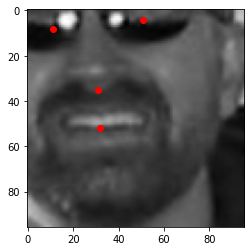

In [44]:
for (x, y) in np.array(test_points[2045]).reshape(-1,2):
    plt.scatter(int(x), int(y), c='r')

plt.imshow(test_imgs[2045], cmap='gray')
plt.show()

In [20]:
import matplotlib.pyplot as plt

for idx in range(100):
    for (x, y) in np.array(test_points[idx]).reshape(-1,2):
        plt.scatter(int(x), int(y), c='r')

    plt.imshow(test_imgs[idx], cmap='gray')
    plt.show()


Bad key text.latex.unicode in file /home/fqh/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/fqh/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/fqh/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.c

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

KeyboardInterrupt: 

In [45]:
pd.DataFrame(test_points, columns=col).to_csv('9_2.csv', index=None)

In [55]:
transform_HorizontalFlip = A.Compose(
    [A.HorizontalFlip(p=1)], 
)

aug_test = []
for img in test:
    transformed = transform_HorizontalFlip(image=img)
    aug_test.append(transformed['image'])
    
test_scale = np.array(aug_test)

test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_scale, torch.ones((2049, 8)),
                    transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    ),
    batch_size=10, shuffle=False, num_workers=5,
)

In [37]:
test_scale[0].shape

(192, 192)

In [8]:
pred_tta = []
for path in ['model_0.pt' ,'model_1.pt','model_2.pt','model_3.pt','model_4.pt']:
    pred = []
    model.load_state_dict(torch.load(path))
    model.eval()
    with torch.no_grad():
        for t, (x, y) in enumerate(test_loader):
            x_var = Variable(x).cuda(async=True)
            y_var = Variable(y).cuda()
            scores = model(x_var)
            pred.append(scores.data.cpu().numpy())
    pred = np.concatenate(pred, 0)    
    print(path)
    pred_tta.append(pred)

pred_aug = np.mean(pred_tta, axis=0)

pred_aug = pred_aug * 96 + 96

NameError: name 'model' is not defined

In [61]:
pred_aug.shape

(2049, 8)

In [62]:
# 再翻转回来
aug_test_points = []
transform_RandomContrast = A.Compose(
    [A.HorizontalFlip(p=1)], 
    keypoint_params=A.KeypointParams(format='xy')
)



# for i in range(len(aug_test)):
#     transformed = transform_RandomContrast(image=aug_test[i],keypoints=pred_aug[i].reshape(-1,2))
#     aug_test_points.append(list(chain.from_iterable(transformed['keypoints'][[1, 0, 2, 3]])))

for i in range(pred_aug.shape[0]):
    aug, pnt = flip(aug_test[i], pred_aug[i])
    aug_test_points.append(pnt)

pd.DataFrame(np.array(aug_test_points), columns=col)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,132.511200,78.687752,67.979271,75.996902,99.784378,124.813370,96.644455,148.553116
1,127.156624,70.896820,62.005310,71.758743,91.576256,110.939911,93.947998,152.912735
2,131.582916,70.285454,58.170959,85.600609,102.104843,130.564117,107.521729,155.689529
3,138.471420,71.466400,54.073914,69.488602,96.354752,121.162354,94.921028,149.645630
4,120.840401,78.963890,63.248596,71.422440,108.178413,128.026367,94.708191,155.053909
...,...,...,...,...,...,...,...,...
2044,126.150711,84.735878,61.367538,78.587570,106.641129,125.174950,102.595345,160.083878
2045,95.113075,49.619690,43.149475,57.059196,65.670975,84.702408,66.680962,107.640686
2046,134.485184,80.250023,60.528595,78.820732,98.257919,135.855011,97.174202,159.522797
2047,135.690567,74.325691,58.920319,74.248215,99.970184,120.588028,100.033966,150.546097


In [70]:
pd.DataFrame((np.array(aug_test_points) / 2 + np.array(test_points))/2, columns=col).to_csv('submit825_3.csv', index=None)